In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)

from sklearn.linear_model import LinearRegression

In [3]:
folder = 'data/'
state = 'fl_statewide_2020_04_01.zip'
state2 = 'ca_long_beach_2020_04_01.csv'

# Preprocessing whole dataset (do not execute if working on full data)

In [ ]:
df_full = pd.read_csv(folder + state)
print(df_full.columns)

Reducing the amount of data for experimentation

In [ ]:
cut_file_path = folder + state.split('.')[0] + "_cut.csv"
total_size = df_full.shape[0]
df = df_full.sample(n=int(total_size/100))
print("Full dataset of size {} was reduced to subset of {} elements.".format(total_size, df.shape[0]))
df.to_csv(cut_file_path, index = False)

# Load the data (currently loading all data)

In [39]:
df =  pd.read_csv(folder + state)
print("Dataset is composed of {} stops. Columns are: \n".format(df.shape[0]))
for col in df.columns:
    if df.dtypes[col] != np.float64:
        val = df[col].unique()
        if len(val) > 20:
            print('{} \t\t: too much different values'.format(col))
        else:
            print('{} \t\t: values are: {}'.format(col if len(col)>15 else col + "\t\t", val))
df = df.rename(columns={'officer_years_of_service': 'officer_yos'})

Dataset is composed of 7297538 stops. Columns are: 

raw_row_number 		: too much different values
date 		: too much different values
time 		: too much different values
location 		: too much different values
county_name 		: too much different values
subject_race		 		: values are: [nan 'white' 'black' 'hispanic' 'asian/pacific islander' 'other' 'unknown']
subject_sex		 		: values are: ['female' 'male' nan]
officer_id_hash 		: too much different values
officer_race		 		: values are: [nan 'black' 'white' 'hispanic' 'unknown' 'asian/pacific islander' 'other']
officer_sex		 		: values are: [nan 'male' 'female']
department_name		 		: values are: ['FLORIDA HIGHWAY PATROL' 'FLORIDA HIGHWAY PATROL - TROOP K'
 'FLORIDA HIGHWAY PATROL  MOTORS SQ' 'FLORIDA DEPARTMENT OF AGRICULTURE'
 nan]
unit 		: too much different values
type		 		: values are: ['vehicular']
violation 		: too much different values
arrest_made		 		: values are: [nan False True]
citation_issued		 		: values are: [True False nan]
war

# Preprocess to compare search rates

Calculate search rates for each officer race and each subject race across each county

# General functions

In [6]:
minority_race = ['black', 'hispanic']

def remove_general_unused_columns(data):
    columns_unused = ['officer_id_hash', 'vehicle_registration_state', 'type']
    columns_reasons = ['reason_for_stop', 'reason_for_search', 'notes', 'violation', 'search_basis']
    columns_raw = ['raw_EnforcementAction', 'raw_SearchType', 'raw_Ethnicity', 'raw_row_number_new', 'raw_Race', 'raw_row_number_old', 'raw_row_number']
    columns_geography = ['location', 'department_name', 'unit']
    return data.drop(columns=columns_unused + columns_reasons + columns_raw + columns_geography)

def print_search_rate(data):
    number_stops = data['search_conducted'].shape[0]
    number_search_conducted = data[data['search_conducted'] == True].shape[0]
    print('Data contains {} stops and {} of them ({}%) resulted in searches.'.format(number_stops, number_search_conducted, 100 * float(number_search_conducted)/number_stops))

def preprocess_for_grouping(data):
    data['search_rate'] = data['search_conducted']
    data = data.astype({'search_rate': float})
    data['count'] = 1 # to count occurences
    return data

def separate_data(data, categories):
    df = {}
    for exp in categories:
        df[exp] = data.loc[exp]
    return df


In [25]:
from scipy.stats import linregress

def plot_race(data, min_race, categories, threshold, what_to_plot, ax_limits=None, filename='test.html'):

    fig, ax_arr = plt.subplots(1, 3) # 2 graphs
    figsize = (14,5)
    fig.set_size_inches(14,5) # fig size
    fig.suptitle(min_race.title() + " people search rates among officers".format(min_race))

    fig = make_subplots(rows=1, cols=3)
    for i, off_feat in enumerate(categories):
        filename = off_feat + '_' + filename

        data_ = data[off_feat]
        df_white_sub, df_minority = data_.loc['white'], data_.loc[min_race] #separate data
        df_white_sub.reset_index(inplace=True), df_minority.reset_index(inplace=True) #reset index
        df_merged = pd.merge(df_white_sub, df_minority, on='county_name', suffixes=['_white', '_minority']) # merge both

        # remove where there are too little datapoints
        cond_minority = df_merged['count_minority'] >= threshold

        x = df_merged[what_to_plot + '_white'][cond_minority]*100
        y = df_merged[what_to_plot + '_minority'][cond_minority]*100
        s = df_merged['count_minority'][cond_minority]/100

        ax_arr[i].scatter(x, y, s=s, c="None", edgecolors='black', linewidth=0.4)
        ax_arr[i].set_xlabel("White " + what_to_plot + " (%)")
        ax_arr[i].set_ylabel(min_race.title() + " "+ what_to_plot +" (%)")

        #plot regression
        a, b, r, p_value, std_err = linregress(x.repeat(s), y.repeat(s))
        sns.regplot(x=x.repeat(s), y=y.repeat(s), ax=ax_arr[i], label='{:.1f}*x + {:.1f}, r={:.2f}'.format(a,b,r), scatter=False, truncate=False).legend(loc="best")

        ax_arr[i].set_title(off_feat.title() +' officers')

        line=None
        if what_to_plot == 'search_rate':
            # draw dotted line
            max_ = df_merged[what_to_plot + '_minority'][cond_minority].max()
            line = np.arange(0, max_ * 100, max_)
            ax_arr[i].plot(line, line, c='black', linestyle=(0,(5,5)), linewidth=1)



        if ax_limits is None:
            max_x = 1
            max_y = 1
            reg_line = np.array(((0,b), (1, a + b)))
        else:
            max_x = ax_limits['x']
            max_y = ax_limits['y']
            reg_line = np.array(((0, b), (max_x, a*max_x + b)))

        
        color = px.colors.qualitative.Plotly[i]
        fig.add_trace(go.Scatter(
            x=x, 
            y=y, 
            mode='markers',
            marker=dict(size=np.sqrt(s), opacity=0.5, color=color),
            text='size:' + s.astype(str),
            name=off_feat.title() +' officers',
            ), 
            row=1, col=i+1
            )

        if line is not None:
            fig.add_shape(type="line",
                x0=line[0], y0=line[0], x1=line[-1], y1=line[-1],
                line=dict(
                    color="Grey",
                    width=1,
                    dash="dot",
                ), row=1, col=i+1,
            )

        fig.add_trace(go.Scatter(
            x=reg_line[:,0], y=reg_line[:,1],
            mode='lines',
            name='{:.1f}*x + {:.1f}, r={:.2f}'.format(a,b,r),
            line=dict(
                color=color,
                width=2,
                dash="solid")
            ),
            row=1, col=i+1
        )

        fig.update_xaxes(title_text="White " + what_to_plot + " (%)", range=[0, max_x], row=1, col=i+1)
        fig.update_yaxes(title_text=min_race.title() + " "+ what_to_plot +" (%)", range=[0, max_y], row=1, col=i+1)

    fig.update_layout(autosize=True, width=figsize[0]*100*0.7, height=figsize[1]*100*0.8, title_text=min_race.title() + " people search rates among officers".format(min_race))
    fig.write_html(filename)
    fig.show()


def plot_search_rates(data, categories, threshold=500, what_to_plot='search_rate', ax_limits=None, filename='test.html'):
    for i, race in enumerate(minority_race):
        filename=race + '_' + filename
        plot_race(data, race, categories, threshold, what_to_plot, ax_limits[i] if ax_limits else None, filename=filename)


def plot_one_search_rate(data, categories, threshold=500, what_to_plot='search_rate', ax_limits=None):
    for i, race in enumerate(minority_race):
        plot_race(data, race, categories, threshold, what_to_plot, ax_limits[i] if ax_limits else None)
        break


# # separate data
# df_race_sep = separate_data(df_race_mixed, officer_race)
# df_race_sep[officer_race[0]].head(2)

# # plot it 
# plot_search_rates(df_race_sep, officer_race, 100, what_to_plot='stop_rate')

# Race of officer

In [8]:
officer_race = ['white', 'black', 'hispanic']

In [9]:
df_race = copy(df)

# remove unused columns
df_race = remove_general_unused_columns(df_race)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_race', 'search_conducted']
df_race.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_race.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_race)

# preprocess for grouping
df_race = preprocess_for_grouping(df_race)

# add specific column for this type of analyzis
df_race_all = df_race.groupby(['officer_race','subject_race','county_name']).agg({'search_rate': 'mean', 'count':'count'})

Cleaned subset is composed of 4191965 datapoints
Data contains 4191965 stops and 25708 of them (0.6132684791022825%) resulted in searches.


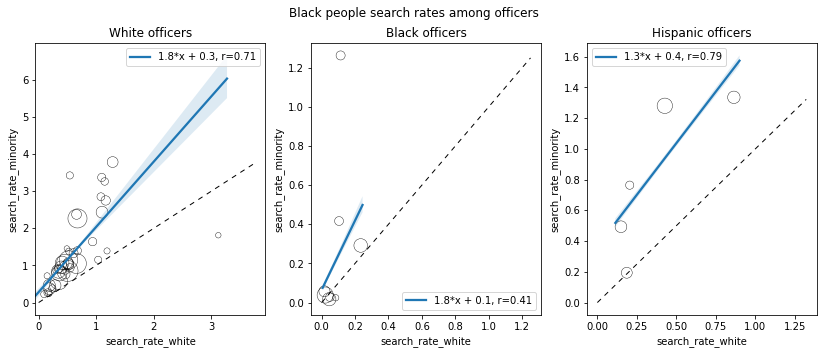

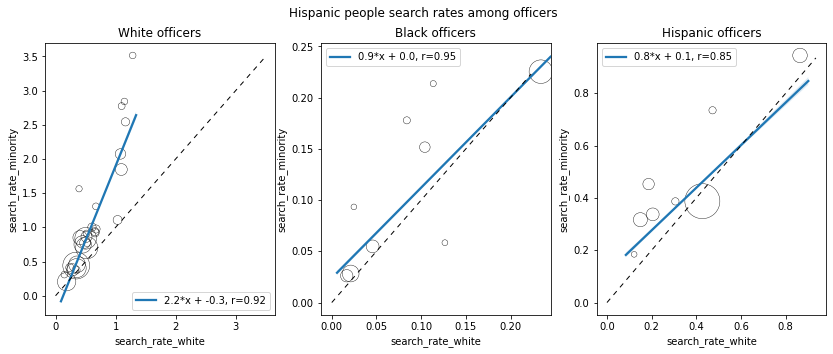

In [10]:
# separate data
df_race_sep = separate_data(df_race_all, officer_race)
df_race_sep[officer_race[0]].head(2)

# plot it 
ax_limits = [
    {'x':2, 'y':4},
    {'x':2, 'y':4},
]
plot_search_rates(df_race_sep, officer_race, 3000, filename='search_rate.html', ax_limits=ax_limits )

# Experience of officer

In [11]:
officer_experience_level = ['young', 'experienced', 'old']
thresholds_experience = [2, 9]

Preprocess the data to have what is needed

In [16]:
df_yos = copy(df)

# remove unused columns
df_yos = remove_general_unused_columns(df_yos)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_yos', 'search_conducted']
df_yos.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_yos.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_yos)

# preprocess for grouping
df_yos = preprocess_for_grouping(df_yos)

# add specific column for this type of analyzis
df_yos['age_category'] = df_yos['officer_yos'].apply(lambda x : officer_experience_level[0] if x < thresholds_experience[0] else (officer_experience_level[1] if x < thresholds_experience[1] else officer_experience_level[2]))
df_yos_all = df_yos.groupby(['age_category','subject_race','county_name']).agg({'search_rate': 'mean', 'count':'count'})

Cleaned subset is composed of 4995855 datapoints
Data contains 4995855 stops and 28712 of them (0.5747164399287009%) resulted in searches.


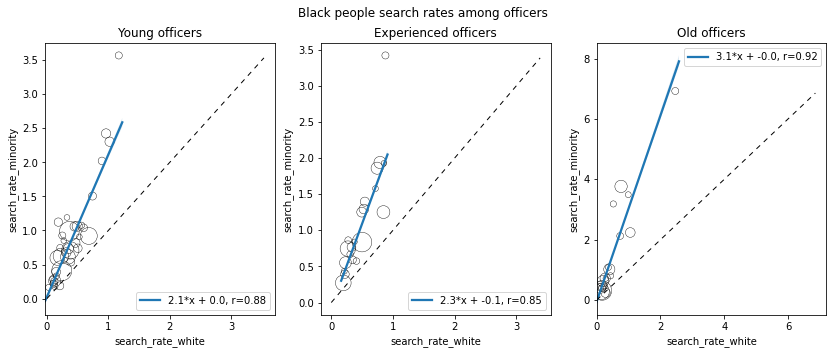

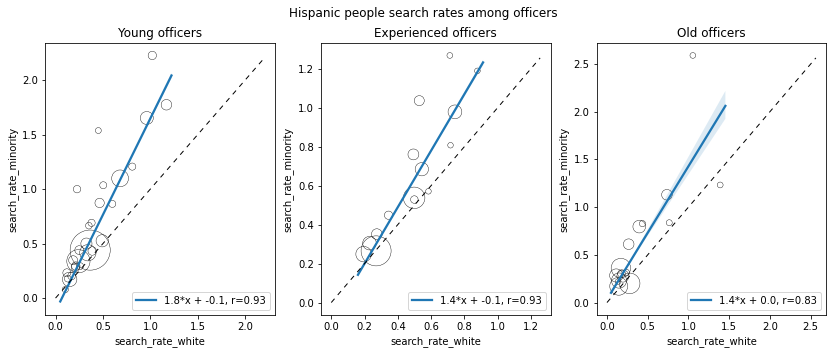

In [18]:
# separate data
df_yos_sep = separate_data(df_yos_all, officer_experience_level)
df_yos_sep[officer_experience_level[0]].head(2)

# plot it 


ax_limits = [
    {'x':2, 'y':4},
    {'x':2, 'y':4},
]
plot_search_rates(df_yos_sep, officer_experience_level, 3000, ax_limits=ax_limits, filename='yos_search_rate.html')

# Age of the officer

In [19]:
officer_age_level = ['young', 'experienced', 'old']
thresholds_age = [30, 50]

In [20]:
df_age = copy(df)

# remove unused columns
df_age = remove_general_unused_columns(df_age)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_age', 'search_conducted']
df_age.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_age.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_age)

# preprocess for grouping
df_age = preprocess_for_grouping(df_age)

# add specific column for this type of analyzis
df_age['age_category'] = df_age['officer_age'].apply(lambda x : officer_age_level[0] if x < thresholds_age[0] else (officer_age_level[1] if x < thresholds_age[1] else officer_age_level[2]))
df_age_all = df_age.groupby(['age_category','subject_race','county_name']).agg({'search_rate': 'mean', 'count':'count'})

Cleaned subset is composed of 4423122 datapoints
Data contains 4423122 stops and 26619 of them (0.6018147362880789%) resulted in searches.


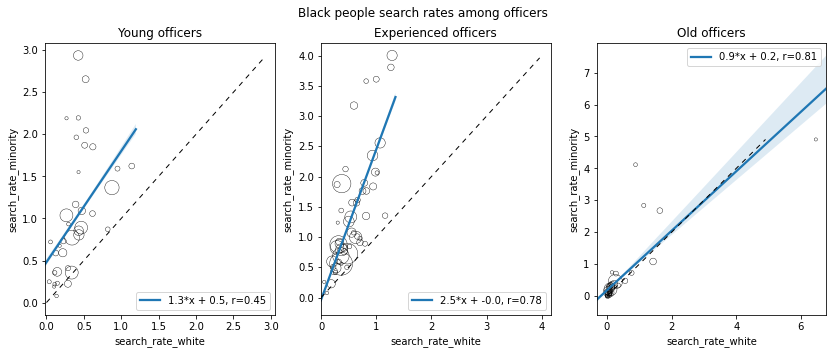

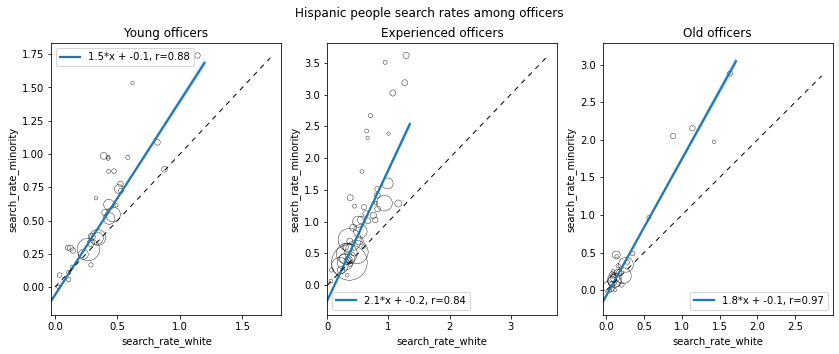

In [21]:
# separate data
df_age_sep = separate_data(df_age_all, officer_age_level)
df_age_sep[officer_age_level[0]].head(2)

# plot it 
plot_search_rates(df_age_sep, officer_age_level, 1000, ax_limits=[{'x': 1.5, 'y':3},{'x': 2, 'y':3}])

# Logistic regression of characteristics of officers

In [27]:
officer_race = ['white', 'black', 'hispanic']

In [28]:
df_race = copy(df)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_race', 'search_conducted']
df_race.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_race.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_race)
df_race = preprocess_for_grouping(df_race)

# add specific column for this type of analyzis
df_race_all_s = df_race.groupby(['officer_race','county_name', 'subject_race']).agg({'count':'count'})
df_race_all = df_race.groupby(['officer_race','county_name']).agg({'count':'count'})

df_race_mixed = copy(df_race_all_s)
df_race_mixed['tot'] = df_race_all['count']
df_race_mixed['stop_rate'] = df_race_mixed['count'] / df_race_mixed['tot']


df_race_mixed = df_race_mixed.reorder_levels(['officer_race','subject_race','county_name'])

df_race_mixed.head()

Cleaned subset is composed of 4191965 datapoints
Data contains 4191965 stops and 25708 of them (0.6132684791022825%) resulted in searches.


count  tot  \
officer_race           subject_race           county_name                  
asian/pacific islander asian/pacific islander Broward County      9  838   
                       black                  Broward County    248  838   
                       hispanic               Broward County    202  838   
                       other                  Broward County     24  838   
                       white                  Broward County    355  838   

                                                              stop_rate  
officer_race           subject_race           county_name                
asian/pacific islander asian/pacific islander Broward County   0.010740  
                       black                  Broward County   0.295943  
                       hispanic               Broward County   0.241050  
                       other                  Broward County   0.028640  
                       white                  Broward County   0.423628

In [29]:

df = separate_data( df_race_mixed, ['white'])['white']
df.reset_index(level=[0,1], inplace=True)
df.head()

,subject_race,county_name,count,tot,stop_rate
0,asian/pacific islander,Alachua County,714,47482,0.015037
1,black,Alachua County,11816,47482,0.248852
2,hispanic,Alachua County,4382,47482,0.092288
3,other,Alachua County,996,47482,0.020976
4,white,Alachua County,29574,47482,0.622847


In [30]:
print(df[df.subject_race == 'black']['count'].sum())
print(df['count'].sum())

549048
2926281


In [31]:
from scipy.stats import linregress

def plot_race_stop(data, min_race, categories, threshold):

    what_to_plot = 'stop_rate'

    fig, ax_arr = plt.subplots(1, 3) # 2 graphs
    fig.set_size_inches(17,5) # fig size
    fig.suptitle(min_race.title() + " people "+ what_to_plot+" among officers".format(min_race))

    for i, off_feat in enumerate(categories):

        data_ = data[off_feat]
        df_white_sub, df_minority = data_.loc['white'], data_.loc[min_race] #separate data
        df_white_sub.reset_index(inplace=True), df_minority.reset_index(inplace=True) #reset index
        df_merged = pd.merge(df_white_sub, df_minority, on='county_name', suffixes=['_white', '_minority']) # merge both

        # remove where there are too little datapoints
        cond_minority = df_merged['count_minority'] >= threshold

        y = df_merged[what_to_plot + '_minority'][cond_minority]*100
        total =  float(df_merged['count_minority'].sum())
        print(total)
        s = df_merged['count_minority'][cond_minority] #.apply(lambda x: x / total)

        sns.histplot(y.repeat(s), ax=ax_arr[i], bins=8, kde=True)


        ax_arr[i].set_xlabel(min_race.title() + what_to_plot + " (%)")
        ax_arr[i].set_ylabel("Number of " + min_race +" stops")


        ax_arr[i].set_title(off_feat.title() +' officers')



def plot_stop_rates(data, categories, threshold= 0):
    for race in minority_race + ['white']:
        plot_race_stop(data, race, categories, threshold)


# separate data
df_race_sep = separate_data(df_race_mixed, officer_race)
df_race_sep[officer_race[0]].head(2)


,,count,tot,stop_rate
subject_race,county_name,,,
asian/pacific islander,Alachua County,714,47482,0.015037
black,Alachua County,11816,47482,0.248852


549048.0
134621.0
87720.0
514618.0
166257.0
217553.0
1751092.0
314020.0
194114.0


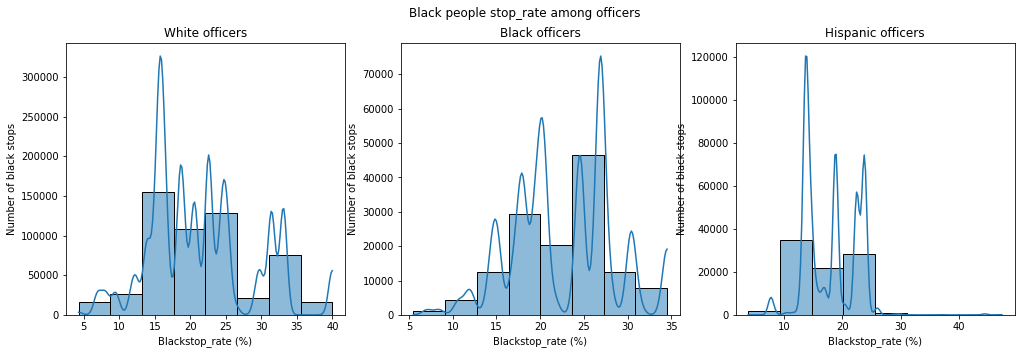

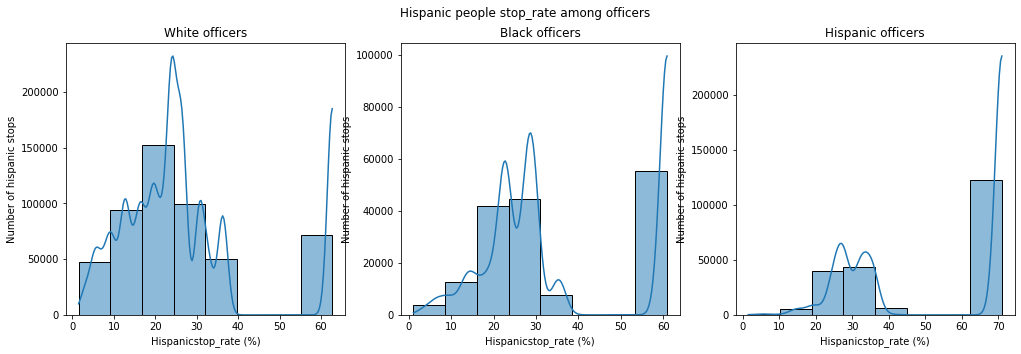

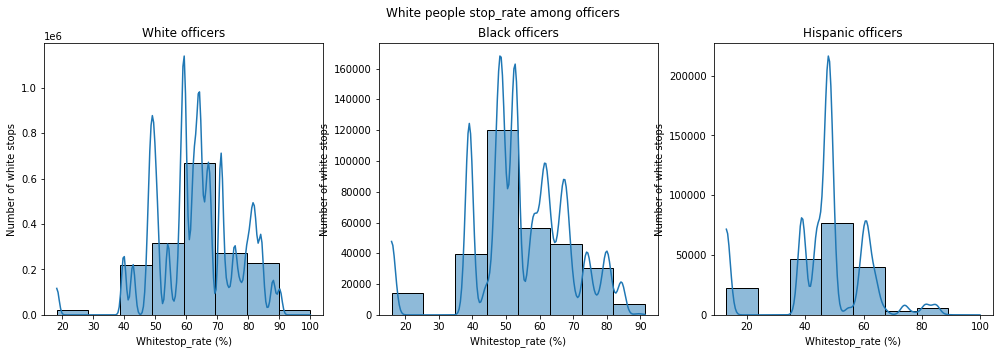

In [32]:

# plot it 
plot_stop_rates(df_race_sep, officer_race, 0)

# Veil of darkness

In [34]:
import datetime
from matplotlib.pyplot import figure
from tqdm.notebook import tqdm, tqdm_notebook
from datetime import datetime
tqdm.pandas()

In [40]:

# s = sun(cityobserver, date=datetime.date())

# def plot_veil_of_darkness(data, period= ['01-12', '20-12'], sunset_time='17:3', hour_range=[15,20]):
CHOSEN_CHARACTERISTIC = 'officer_race'

df_veil = copy(df)
# remove unused columns
columns_time = ['date','time']
columns_to_drop = ['subject_sex', 'subject_age', 'arrest_made', 'citation_issued', 'warning_issued', 'outcome', 'frisk_performed', 'search_conducted']
df_veil = remove_general_unused_columns(df_veil)
df_veil.drop(columns=columns_to_drop, inplace=True)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', CHOSEN_CHARACTERISTIC ]
df_veil.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_veil.shape[0]))

df_veil['date'] = (df_veil['date'] + ' ' + df_veil['time']).progress_apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_veil.drop(columns=['time'], inplace=True)
df_veil.head()

Cleaned subset is composed of 4194281 datapoints


,date,county_name,subject_race,officer_age,officer_race,officer_sex,officer_yos
1,2010-01-06 16:14:43,Duval County,white,31.0,black,male,8.0
2,2010-01-08 19:39:31,Duval County,white,29.0,white,male,3.0
3,2010-01-11 11:56:34,St. Lucie County,white,26.0,white,male,3.0
6,2010-01-15 09:18:02,Gadsden County,white,47.0,white,male,0.0
7,2010-01-15 10:16:59,Gadsden County,hispanic,47.0,white,male,0.0


In [43]:
import astral.sun as astralsun
from astral import LocationInfo
from astral.sun import sun
from datetime import datetime

city = LocationInfo("Orlando")

df_veil['dusk_time'] = df_veil['date'].progress_apply(lambda x : sun(city.observer, date=x)['dusk'].replace(tzinfo=None))
df_veil['time_relative'] = df_veil['date'] - df_veil['dusk_time'] #.progress_apply(lambda x : x - )
df_veil.head()

KeyboardInterrupt: 

In [ ]:
from datetime import timedelta

WIDTH = 20 # number of period of 15 minutes
EXTEND= 2 # extend to take more data before the dusk time than after

categories = [timedelta(minutes=15*i) for i in range(-WIDTH-EXTEND, WIDTH+1)]
def get_category(timed):
    for i, t in enumerate(categories):
        if timed < t:
            return i-WIDTH-EXTEND-1 if i else -1
    return -1

# Add a column with their time category (by small periods of 15 minutes. cat 0 is between 0 and 15 BEFORE dusk, 1 is 15 min just AFTER dusk, -1 is between 30 and 15 min BEFORE ). All cat = 0 are out of range arrests, clear them
df_veil['time_cat'] = df_veil['time_relative'].progress_apply(lambda x : get_category(x))
df_veil_cleaned = df_veil[df_veil['time_cat'] != -1]
df_veil_cleaned.head()

In [46]:
# df_for_vod = copy(df_veil_cleaned)

def get_time_category(time):
    if time.minute < 7.5:
        return f"{time.hour}:00"
    elif 7.5 < time.minute < 22.5:
        return f"{time.hour}:15"
    elif 22.5 < time.minute < 37.5:
        return f"{time.hour}:30"
    elif 37.5 < time.minute < 52.5:
        return f"{time.hour}:45"
    else:
        return f"{time.hour + 1}:00"

# # Add a column with their dusk time moment
# df_for_vod['dusk_exact_time'] = df_for_vod['dusk_time'].progress_apply(lambda x : x.time())
# df_for_vod['dusk_category'] = df_for_vod['dusk_exact_time'].progress_apply(lambda x : get_time_category(x))
# df_for_vod.head()

In [ ]:
df_veil_cleaned.to_csv('data_with_dusk.csv')
df_veil_cleaned.head()

In [44]:
from datetime import datetime

df_for_vod = pd.read_csv('data_with_dusk.csv')
df_for_vod['date_obj'] = df_for_vod['date'].progress_apply(lambda x : datetime.strptime(x.split('.')[0], '%Y-%m-%d %H:%M:%S'))

In [47]:
df_for_vod['date_category'] = df_for_vod['date_obj'].progress_apply(lambda x : get_time_category(x))

print(df_for_vod.shape)
df_for_vod.head()


(1907174, 16)


,Unnamed: 0,Unnamed: 0.1,date,county_name,subject_race,officer_age,officer_race,officer_sex,officer_yos,dusk_time,time_relative,time_cat,dusk_exact_time,dusk_category,date_obj,date_category
0,0,1,2010-01-06 16:14:43.000000,Duval County,white,31.0,black,male,8.0,2010-01-06 16:47:27.315541,-1 days +23:27:15.684459,-3,16:47:27.315541,16:45,2010-01-06 16:14:43,16:15
1,1,2,2010-01-08 19:39:31.000000,Duval County,white,29.0,white,male,3.0,2010-01-08 16:49:51.078852,0 days 02:49:39.921148,11,16:49:51.078852,16:45,2010-01-08 19:39:31,19:45
2,2,3,2010-01-11 11:56:34.000000,St. Lucie County,white,26.0,white,male,3.0,2010-01-11 16:53:40.884170,-1 days +19:02:53.115830,-20,16:53:40.884170,17:00,2010-01-11 11:56:34,12:00
3,3,8,2010-01-15 12:30:12.000000,Leon County,hispanic,47.0,white,male,0.0,2010-01-15 16:59:10.798986,-1 days +19:31:01.201014,-18,16:59:10.798986,17:00,2010-01-15 12:30:12,12:30
4,4,10,2010-01-15 13:55:22.000000,Gadsden County,black,32.0,white,male,5.0,2010-01-15 16:59:10.798986,-1 days +20:56:11.201014,-13,16:59:10.798986,17:00,2010-01-15 13:55:22,14:00


In [54]:
df_new_version = copy(df_for_vod)

In [48]:
def group_data(df_to_group):
    df_to_group['count'] = 1

    # group the categories
    df_vod = df_to_group.groupby(['time_cat','subject_race']).agg({'count':'count'})
    df_grouped_by_timecat = df_to_group.groupby('time_cat').agg({'count':'count'})

    # merge both
    df_vod.reset_index(inplace=True)
    df_grouped_by_timecat.reset_index(inplace=True)
    df_vod = df_vod.merge(df_grouped_by_timecat, on=['time_cat'])

    # compute the stop_rate
    df_vod['race_stop_rate'] = df_vod['count_x'] / df_vod['count_y']
    return df_vod

In [55]:
def plot_vod_1sub_1off(data_o, time_range=[-8,7], plot=True, dusk_time=None, off_cat='all', filename='test.html', factor_size=None):
    data = copy(data_o)
    data = data[data['time_cat'].isin(range(time_range[0],time_range[1]))]
    data = data[~data['time_cat'].isin(range(-1,0))]

    data['time_cat'] = data['time_cat'] * 10
    data['race_stop_rate'] = data['race_stop_rate'] * 100

    # two different regressions
    data_before = data[data['time_cat'] < -1]
    data_after = data[data['time_cat'] > -1]

    # calculate means
    if data_before['count_y'].sum() == 0:
        before_average = np.nan
    else:
        before_average = np.average(data_before['race_stop_rate'], weights=data_before['count_y'])
    if data_after['count_y'].sum() == 0:
        after_average = np.nan
    else:
        after_average = np.average(data_after['race_stop_rate'], weights=data_after['count_y'])

    # plot
    if plot:

        # plot points
        figure(figsize=(10,5))
        ax = sns.scatterplot(x='time_cat', y='race_stop_rate', size='count_y', sizes=(20,200) ,data=data, color='black')
        plt.axvline(0, c='black', linestyle='dashed')

        # plot averages
        plt.hlines(before_average, -80, -20)
        plt.hlines(after_average, 0, 60)

        # set axes
        ax.set_xlabel('Time since dusk (min)')
        ax.set_ylabel('Stopped drivers who are black (%)')

        if dusk_time :
            title = f"Stops at {dusk_time} by {off_cat} officers"
        else:
            title = f"All stops by {off_cat} officers"
        ax.set_title(title)


        # plotly version
        fig = make_subplots(rows=1, cols=1)
        min_x, max_x = -90, 70
        min_y, max_y = data['race_stop_rate'].min(), data['race_stop_rate'].max()
        offset = (max_y - min_y)*0.1
        min_y, max_y = min_y-offset, max_y+offset
        figsize = (10,5)
        
        
        color = px.colors.qualitative.Plotly[0]
        m = data['count_y'].min()
        M = data['count_y'].max()
        sizes = data['count_y'] / data['count_y'].max() * 500
        sizes /= 20
        if factor_size is not None:
            sizes *=  factor_size

        fig.add_trace(go.Scatter(
            x=data['time_cat'],
            y=data['race_stop_rate'], 
            mode='markers',
            marker=dict(size=sizes, opacity=0.9, color=color),
            text='count: ' + data['count_y'].astype(str),
            name='Number of stops',
            ), 
            row=1, col=1
            )

        fig.add_shape(type="line",
            x0=0, y0= min_y, x1=0, y1=max_y,
            line=dict(
                color="Grey",
                width=1,
                dash="dot",
            ), row=1, col=1,
        )

        lin = 15
        xs = np.linspace(min_x, 0, lin)
        ys = np.linspace(before_average, before_average, lin)
        fig.add_trace(go.Scatter(
            x=xs, y=ys,
            mode='lines',
            name='Weighted average',
            text='Weighted mean: ' + str(before_average),
            opacity=0.6,
            line=dict(
                color='Black',
                width=3,
                dash="solid")
            ),
            row=1, col=1
        )

        xs = np.linspace(0, max_x, lin)
        ys = np.linspace(after_average, after_average, lin)
        fig.add_trace(go.Scatter(
            x=xs, y=ys,
            mode='lines',
            name='Weighted average',
            text='Weighted mean: ' + str(after_average),
            opacity=0.6,
            line=dict(
                color='Black',
                width=3,
                dash="solid")
            ),
            row=1, col=1
        )

        fig.update_xaxes(title_text='Time since dusk (min)', range=[min_x, max_x], row=1, col=1)
        fig.update_yaxes(title_text='Stopped drivers who are black (%)', range=[min_y, max_y], row=1, col=1)
        print(min_y, max_y)

        # fig.update_layout(autosize=True,width= widfigsize[0]*100*0.7, height=figsize[1]*100*0.8, title_text=title)
        fig.update_layout(autosize=True, title_text=title)
        fig.write_html(filename)
        fig.show()
    return before_average, after_average

# plot_1sub_Aoff(df_to_exploit, plot=True,  off_cat_name=struct['name'], off_cat_values=struct['values'], sub_race= 'black', dusk_time='19:15', county_name=None)

In [56]:
def plot_1sub_Aoff(df__, off_cat_name, off_cat_values, sub_race, \
                            county_name=None, dusk_time=None, plot=True, filename='test.html'):

    df_vod = copy(df__)

    if type(off_cat_values) is dict:
        officer_cat_values_list = [off_cat_values[x] for x in off_cat_values]
        df_vod[off_cat_name+'_cat'] = df_vod[off_cat_name].apply(lambda x : get_off_cat(x, off_cat_values))
        off_cat_name = off_cat_name+'_cat'
        off_cat_values = officer_cat_values_list


    # select only the data from one county
    if county_name:
        df_vod = df_vod[df_vod['county_name'] == county_name]

    # select data from only one dusk time range
    if dusk_time:
        df_vod = df_vod[df_vod['date_category'] == dusk_time]

    if df_vod.shape[0] == 0:
        return None

    # for each cat of officer, plot the graph for the given subject race
    list_hours = []

    if off_cat_name != 'all':

        for cat in off_cat_values:
            df_ = group_data(df_vod[df_vod[off_cat_name] == cat])

            # select only the data of one subject race
            df_ = df_[df_['subject_race'] == sub_race]

            if df_.shape[0] == 0:
                break

            tup = plot_vod_1sub_1off(df_, plot=plot, dusk_time = dusk_time, off_cat=cat, filename= cat + '_' + filename)
            list_hours.append({'cat_off': cat ,'dusk': dusk_time, 'before':tup[0], 'after': tup[1]})
        
    else:
        df_ = group_data(df_vod)
        # select only the data of one subject race
        df_ = df_[df_['subject_race'] == sub_race]

        if df_.shape[0] == 0:
            return None

        tup = plot_vod_1sub_1off(df_, plot=plot, dusk_time= dusk_time, filename=filename)
        list_hours.append({'cat_off': 'all' ,'dusk': dusk_time, 'before':tup[0], 'after': tup[1]})
    
    return list_hours

In [57]:
# df_to_exploit = copy(df_for_vod)
dusk_times = [f"{h}:{m}" for h in range(17,23) for m in ['00','15','30','45']]

def get_off_cat(v, dic):
    for i in dic:
        if v < i:
            return dic[i]
    return -1

# print(df_to_exploit.shape)
# df_to_exploit.head()

In [58]:
def precalculate_each_cat(df__, cat_name, dic_cat, subject_race):
    df_to_exploit = copy(df__)

    if type(dic_cat) is dict:
        officer_cat_values = [dic_cat[x] for x in dic_cat]
        important_column = cat_name+'_cat'
        df_to_exploit[important_column] = df_to_exploit[cat_name].apply(lambda x : get_off_cat(x, dic_cat))
    else:
        important_column = cat_name
        officer_cat_values = dic_cat

    stop_rates_each_period = []
    for dt in tqdm(dusk_times):

        v = plot_1sub_Aoff(df_to_exploit, plot=False,  off_cat_name=important_column, \
                 off_cat_values=officer_cat_values, sub_race= subject_race, dusk_time=dt)
        if v != None:
            for e in v:
                stop_rates_each_period.append(e)

    return pd.DataFrame(stop_rates_each_period), officer_cat_values



In [59]:
def value_of_hour(x):
    s = x.split(':')
    return int(s[0]) + float(s[1])/60


def print_drop_Aoff(df__, off_cat, both_lines=False, filename='test.html'):
    
    colors = ['blue','black','red', 'green', 'yellow', 'pink']
    df__['dusk_i'] = df__['dusk'].apply(lambda x : value_of_hour(x))
    df__.dropna(inplace=True)


    print(df__.head(1))

    fig = make_subplots(rows=1, cols=1)

    def set_range_y_scale(serie):
        min_y, max_y = serie.min(), serie.max()
        offset = (max_y - min_y)*0.1
        min_y, max_y = min_y-offset, max_y+offset
        return min_y, max_y

    figsize = (10,5)

    min_y, max_y = 0.0 ,0.0
    if off_cat:
        for i, cat in enumerate(off_cat):
            df_ = df__[df__['cat_off'] == cat]
            if both_lines:
                min_, max_ = set_range_y_scale(pd.concat([df_['before'],df_['after']]))
                min_y = min_y if min_y<min_ else min_
                max_y = max_y if max_y>max_ else max_
                
                x = df_['dusk_i']
                y = df_['before']
                label = cat + ' officers before dusk'
                plt.plot(x, y, label=label, linestyle='dashed')

                fig.add_trace(go.Scatter(
                    x=x, y=y,
                    mode='lines',
                    name=label,
                    opacity=0.8,
                    line=dict(
                        width=2,
                        dash="dash")
                    ),
                    row=1, col=1
                )

                
                x = df_['dusk_i']
                y = df_['after']
                label = cat + ' officers after dusk'
                plt.plot(x, y, label=label)

                fig.add_trace(go.Scatter(
                    x=x, y=y,
                    mode='lines',
                    name=label,
                    opacity=0.8,
                    line=dict(
                        width=2,
                        dash="solid")
                    ),
                    row=1, col=1
                )

            else:
                x = df_['dusk_i']
                y = df_['before'] - df_['after']
                label = cat + ' officers'
                plt.plot(x, y, label=label)
                
                min_, max_ = set_range_y_scale(y)
                min_y = min_y if min_y<min_ else min_
                max_y = max_y if max_y>max_ else max_
                # plt.hlines(df_['before'].mean() - df_['after'].mean(), 17.25, 21.50,  linestyle='dashed', color=colors[i])

                fig.add_trace(go.Scatter(
                    x=x, y=y,
                    mode='lines',
                    name=label,
                    opacity=0.8,
                    line=dict(
                        width=2,
                        dash="solid")
                    ),
                    row=1, col=1
                )

    else:
        df_ = df__.group(columns=['dusk']).aggr({'before':'mean', 'after':'mean'})
        

        x = df_['dusk_i']
        y = df_['before'] - df_['after']
        label = 'all officers'
        min_, max_ = set_range_y_scale(y)
        min_y = min_y if min_y<min_ else min_
        max_y = max_y if max_y>max_ else max_
        plt.plot(x, y, label=label)
        # plt.hlines(df_['before'].mean() - df_['after'].mean(), 17.25, 21.50,  linestyle='dashed', color=colors[i])

        fig.add_trace(go.Scatter(
            x=x, y=y,
            mode='lines',
            name=label,
            opacity=0.8,
            line=dict(
                width=2,
                dash="solid")
            ),
            row=1, col=1
        )

    fig.add_shape(type="line",
        x0=22, y0= 0, x1=17, y1=0,
        line=dict(
            color="Grey",
            width=2,
            dash="dot",
        ), row=1, col=1,
    )

    min_x, max_x = df_['dusk_i'].min(), df_['dusk_i'].max()
    fig.update_xaxes(title_text='Time period (h)', range=[min_x-0.2, max_x+0.2], row=1, col=1)
    fig.update_yaxes(title_text='Stop rate drop of black people at each time period (%)', range=[min_y, max_y], row=1, col=1)
    print(min_y, max_y)

    # fig.update_layout(autosize=True,width= widfigsize[0]*100*0.7, height=figsize[1]*100*0.8, title_text=title)
    fig.update_layout(autosize=True, title_text='Stop rate drop of black people at each time period')
    fig.write_html(filename)
    fig.show()

    plt.hlines(0, 17, 22, linestyle='dashed', color='black')
    plt.ylabel('Stop rate drop of black people at each time period (%)')
    plt.xlabel('Time period (h)')
    plt.title('Stop rate drop of black people at each time period')
    plt.legend()

## IN THE DATASTORY

First plot : n average on the year, for all officers: see that the vod works

16.829153605015676 19.67269877457965


[{'cat_off': 'all',
  'dusk': '18:00',
  'before': 18.51386971256433,
  'after': 17.651340531359942}]

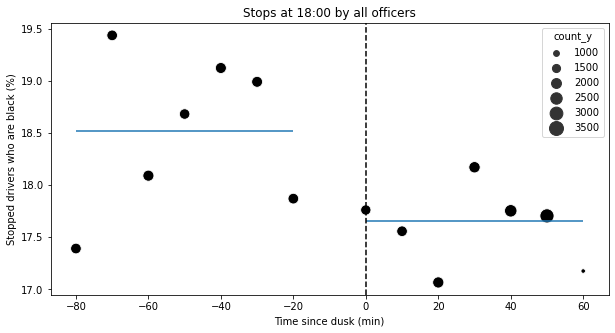

In [60]:
df_to_exploit = copy(df_new_version)

plot_1sub_Aoff(df_new_version, plot=True,  off_cat_name='all', \
                 off_cat_values=['white', 'black', 'hispanic'], sub_race= 'black', dusk_time='18:00', county_name=None, filename='basic_1800.html')

Now lets try to get ride of the hour schedule bias

16.829153605015676 19.67269877457965


16.216027099526467 20.9047946442455


12.391492429704396 21.588320115356886


16.439174986862852 22.059248554913292


[{'cat_off': 'all',
  'dusk': '20:30',
  'before': 20.091946194449175,
  'after': 17.90181856407022}]

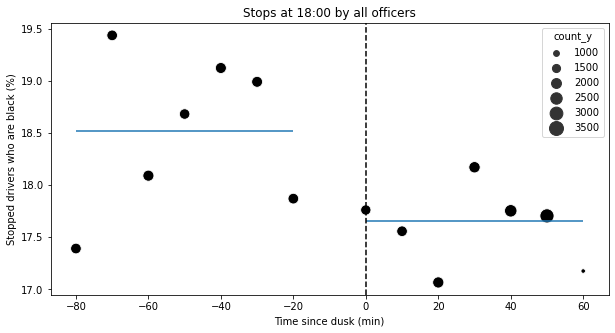

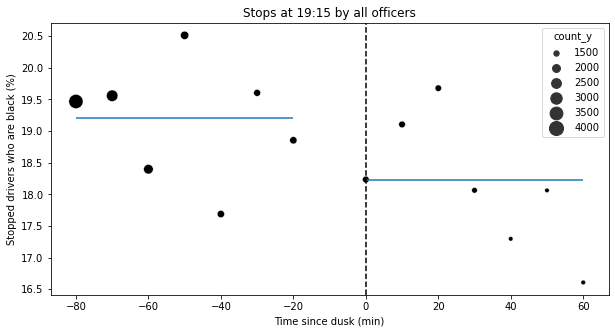

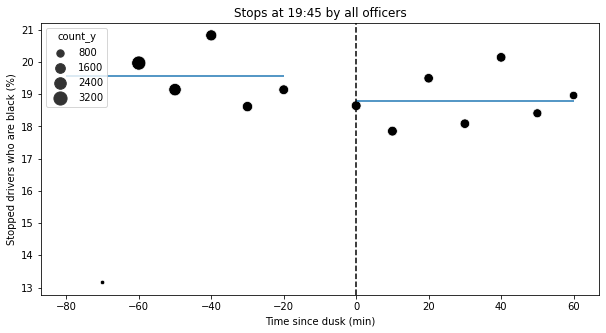

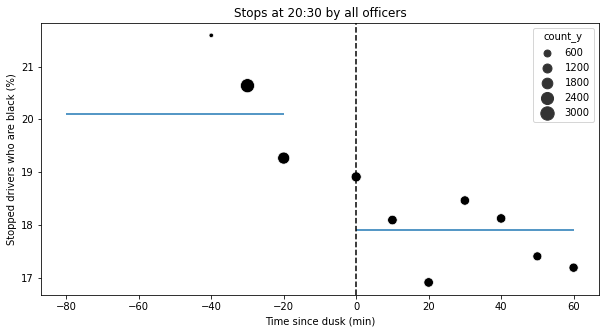

In [61]:
plot_1sub_Aoff(df_to_exploit, plot=True,  off_cat_name='all', \
                 off_cat_values=[], sub_race= 'black', dusk_time='18:00', county_name=None)
plot_1sub_Aoff(df_to_exploit, plot=True,  off_cat_name='all', \
                 off_cat_values=[], sub_race= 'black', dusk_time='19:15', county_name=None)
plot_1sub_Aoff(df_to_exploit, plot=True,  off_cat_name='all', \
                 off_cat_values=[], sub_race= 'black', dusk_time='19:45', county_name=None)
plot_1sub_Aoff(df_to_exploit, plot=True,  off_cat_name='all', \
                 off_cat_values=[], sub_race= 'black', dusk_time='20:30', county_name=None)

Not always consistent: lets show the difference per dusk time

In [65]:
values, cats = precalculate_each_cat(df_to_exploit, cat_name='all', dic_cat=['all'], subject_race=subject_race)

  cat_off   dusk     before      after  dusk_i
0     all  17:00  18.396123  18.189662    17.0
-2.7508542909283067 2.639307805043253


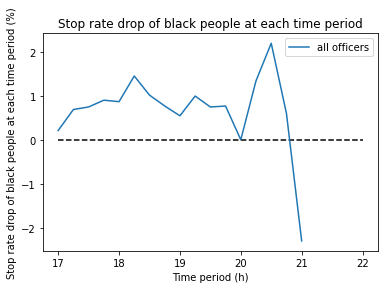

In [66]:
print_drop_Aoff(values, cats, filename='stop_rate_drop_at_eat.html')

Let's try to find out if there are differences between officer races. First define the several categories

In [64]:
officer_race_struct =  {
    'name': 'officer_race',
    'values': ['white', 'black', 'hispanic']
}
officer_yos_struct =  {
    'name': 'officer_yos',
    'values': {2: '0 - 2', 6:' 2 - 6', 10:' 6 - 10', 100: ' > 10'}
}
officer_age_struct =  {
    'name': 'officer_age',
    'values': { 25: '< 25', 35:'25 - 35', 45:'35 - 45', 55:'45 - 55', 100: '> 55'}
}
officer_sex_struct =  {
    'name': 'officer_sex',
    'values': ['male', 'female']
}
struct = officer_race_struct 
subject_race='black'

15.693158639172188 20.638412863842774


15.494480738905159 22.306825861680558


15.241222192441704 22.590458322165638


[{'cat_off': 'white',
  'dusk': '19:15',
  'before': 19.36735045681779,
  'after': 17.981157469717363},
 {'cat_off': 'black',
  'dusk': '19:15',
  'before': 19.383259911894275,
  'after': 19.260129183793307},
 {'cat_off': 'hispanic',
  'dusk': '19:15',
  'before': 18.401727861771057,
  'after': 18.54082998661312}]

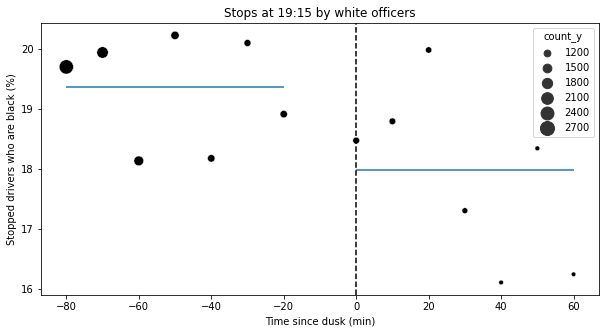

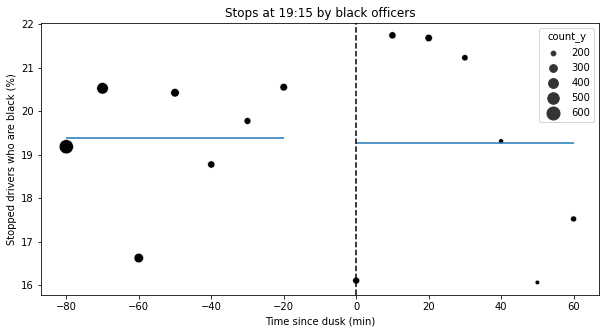

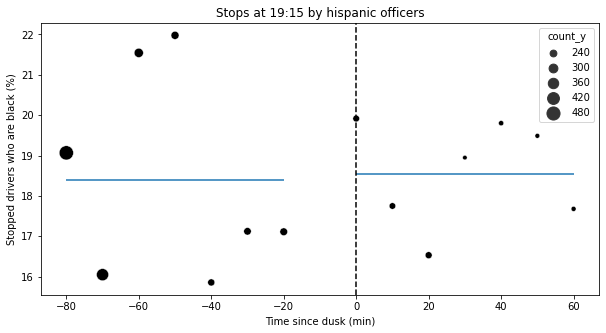

In [69]:
plot_1sub_Aoff(df_to_exploit, plot=True,  off_cat_name=struct['name'], off_cat_values=struct['values'], sub_race= 'black', dusk_time='19:15', county_name=None, filename='1915_white.html')

In [67]:
values, cats = precalculate_each_cat(df_to_exploit, cat_name=struct['name'], dic_cat=struct['values'], subject_race=subject_race)

  cat_off   dusk     before      after  dusk_i
0   white  17:00  17.897822  17.876149    17.0
-2.736524103109198 3.09891282836334


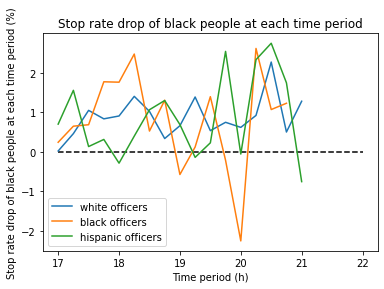

In [68]:
print_drop_Aoff(values, cats, False, filename='html/officer_yos_struct.html')

In [ ]:
figure(figsize=(15,5))
print_drop_Aoff(values, cats, both_lines = True)

# Logistic regression of characteristics of officers

In [ ]:
df_log_raw = copy(df)

# remove unused columns
df_log_raw = remove_general_unused_columns(df_log_raw)
df_log_raw.drop(columns=['arrest_made', 'citation_issued','warning_issued', 'outcome', 'frisk_performed'], inplace=True)
df_log_raw.dropna(inplace=True, subset=['search_conducted'])

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_age', 'officer_yos', 'officer_age']
for feat in important_features:
    m = df_log_raw[feat].mean()
    df_log_raw[feat] = df_log_raw[feat].fillna((m))
print('Cleaned subset is composed of {} datapoints'.format(df_log_raw.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_log_raw)

df_log_raw.head()

In [ ]:
# preprocess for regression
df_log = copy(df_log_raw)

print('Processing sub races')
sub_races = list(df_log['subject_race'].unique())
for race in sub_races:
    df_log['subject_' + (race if isinstance(race, str) else 'nan')] = (df_log['subject_race'] == race).apply(lambda x : int(x))

print('Processing off races')
off_races = list(df_log['officer_race'].unique())
for race in off_races:
    df_log['officer_' + (race if isinstance(race, str) else 'nan')] = (df_log['officer_race'] == race).apply(lambda x : int(x))

print('Processing sub genders')
sub_genders = list(df_log['subject_sex'].unique())
for gender in sub_genders:
    df_log['subject_' + (gender if isinstance(gender, str) else 'nan')] = (df_log['subject_sex'] == gender).apply(lambda x : int(x))

print('Processing off genders')
off_genders = list(df_log['officer_sex'].unique())
for gender in off_genders:
    df_log['officer_' + (gender if isinstance(gender, str) else 'nan')] = (df_log['officer_sex'] == gender).apply(lambda x : int(x))

print('Processing off yos')
cat_exp = [0, 2, 6, 10, 15, 100]
for infi in range(len(cat_exp) -1):
    df_log['officer_exp_' + str(cat_exp[infi]) ] = ( df_log['officer_yos'].between(cat_exp[infi],cat_exp[infi+1], inclusive=[True, False]) ) .apply(lambda x : int(x))

print('Processing off age')
cat_age = [15, 25, 35, 45, 55, 70, 100]
for infi in range(len(cat_age) -1):
    df_log['officer_age_' + str(cat_age[infi]) ] = ( df_log['officer_age'].between(cat_age[infi],cat_age[infi+1], inclusive=[True, False]) ) .apply(lambda x : int(x))


print('Processing search')
df_log['search_conducted'] = df_log['search_conducted'].apply(lambda x : int(x))

print('Removing old columns')
df_log.drop(columns=['subject_race', 'officer_race', 'subject_sex', 'officer_sex', 'officer_yos', 'officer_age'], inplace=True)

df_log.head()

In [ ]:
counties = df_log['county_name'].unique()
maxi = 0
maxi_c = 0
for c in counties:
    v = df_log[df_log['county_name'] == c].shape[0]
    if v > maxi:
        maxi = v
        maxi_c = c

print(maxi_c, maxi )

df_log = df_log[df_log['county_name'] == maxi_c].drop(columns='county_name')

In [ ]:
df_log.head()

In [ ]:
y = df_log['search_conducted'].to_numpy()
x = df_log.drop(columns='search_conducted').to_numpy()
print(x[0], y[0])

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0)
clf.fit(x, y)
params = clf.coef_[0]

In [ ]:
print("Parameters of logistic regression are:")
for i, col in enumerate(df_log.drop(columns='search_conducted').columns):
    print(" - {} : {:.3f} ".format(col,params[i]))

In [ ]:
from xgboost import XGBClassifier, plot_importance, DMatrix

model = XGBClassifier()
model.fit(x, y)

In [ ]:
plot_importance(model).set_yticklabels(df_log.drop(columns='search_conducted').columns[:23])

We see that experienced officers do not search often people. This may be due because they are at a higher level, so they do not do the search themselves. 

# Old stuff

In [ ]:
def plot_officer_race(data, race):
    data_ = data[race]
    df_white_sub, df_black_sub, df_hispanic = data_.loc['white'], data_.loc['black'], data_.loc['hispanic'] #separate data
    df_white_sub.reset_index(inplace=True), df_black_sub.reset_index(inplace=True), df_hispanic.reset_index(inplace=True) #reset index
    df_merged = pd.merge(df_white_sub, df_black_sub, on='county_name', suffixes=['', '_black'])
    df_merged = pd.merge(df_merged, df_hispanic, on='county_name', suffixes=['_white', '_hispanic'])
    fig, ax_arr = plt.subplots(1, 2) # 2 graphs
    fig.set_size_inches(9,5) # fig size

    fig.suptitle("Minorities search rates of {} officers".format(race))

    ax_arr[0].scatter(df_merged['search_rate_white']*100, df_merged['search_rate_black']*100)
    ax_arr[0].set_xlabel("White search rate (%)")
    ax_arr[0].set_ylabel("Black search rate (%)")

    ax_arr[1].scatter(df_merged['search_rate_white']*100, df_merged['search_rate_hispanic']*100)
    ax_arr[1].set_xlabel("White search rate (%)")
    ax_arr[1].set_ylabel("Black search rate (%)")
    

for race in officer_race:
    plot_officer_race(df_officers, race)

In [ ]:
def group_data(df_to_group):
    df_to_group['count'] = 1

    # group the categories
    df_vod = df_to_group.groupby(['time_cat','subject_race']).agg({'count':'count'})
    df_grouped_by_timecat = df_to_group.groupby('time_cat').agg({'count':'count'})

    # merge both
    df_vod.reset_index(inplace=True)
    df_grouped_by_timecat.reset_index(inplace=True)
    df_vod = df_vod.merge(df_grouped_by_timecat, on=['time_cat'])

    # compute the stop_rate
    df_vod['race_stop_rate'] = df_vod['count_x'] / df_vod['count_y']
    return df_vod

In [ ]:
def plot_vod_1sub_1off(data_o, time_range=[-8,7], plot=True, dusk_time=None, off_cat='all'):
    data = copy(data_o)
    data = data[data['time_cat'].isin(range(time_range[0],time_range[1]))]
    data = data[~data['time_cat'].isin(range(-1,0))]

    data['time_cat'] = data['time_cat'] * 10
    data['race_stop_rate'] = data['race_stop_rate'] * 100

    # two different regressions
    data_before = data[data['time_cat'] < -1]
    data_after = data[data['time_cat'] > -1]

    # calculate means
    before_average = data_before['race_stop_rate'].mean()
    after_average = data_after['race_stop_rate'].mean()

    # plot
    if plot:

        # plot points
        figure(figsize=(10,5))
        ax = sns.scatterplot(x='time_cat', y='race_stop_rate', size='count_y', sizes=(20,200) ,data=data, color='black')
        plt.axvline(0, c='black', linestyle='dashed')

        # plot averages
        plt.hlines(before_average, -80, -20)
        plt.hlines(after_average, 0, 60)

        # set axes
        ax.set_xlabel('Time since dusk (min)')
        ax.set_ylabel('Percentage of stopped drivers who are black')

        if dusk_time :
            ax.set_title(f"Dusk time at {dusk_time} : stops by {off_cat} officers")
        else:
            ax.set_title(f"All dusk times : stops by {off_cat} officers")

    return before_average, after_average